Importing Libraries

In [26]:
#------------ Imports ------------#

import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mimage
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Common Variables

In [54]:
#------------ Path to Dataset 1 ------------#
DATASET_1_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Dataset 1 for Dataset 3/"

#------------ Path for Training Dataset 3 ------------#
DATASET_3_TRAIN_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Dataset 3/"

#------------ Path for Testing Dataset 3 ------------#
DATASET_3_TEST_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Dataset 3 Test/"

#------------ Path for CLear Testing Dataset 3 (optional) ------------#
DATASET_3_TEST_CLEAR_ALPHABETS_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Dataset 3 Clear Test Images/Alphabets/"

#------------ Path for Clear Testing Dataset 3 (optional) ------------#
DATASET_3_TEST_CLEAR_SIGNS_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Dataset 3 Clear Test Images/Signs/"

#----------- Path of the Noisy dataset for Dataset 1 -------------------#
NOISY_DATASET_1_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Noisy Dataset 1/"

#----------- Path of the Noisy dataset for Dataset 2 -------------------#
NOISY_DATASET_2_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Noisy Dataset 2/"

#----------- Path of the Noisy dataset for Dataset 3 -------------------#
NOISY_DATASET_3_PATH = "C:/Users/venky/OneDrive/Desktop/NN/Assignment 2/new/Noisy Dataset 3/"

#---------- Required Standard Deviations -----------------#
STANDARD_DEVIATIONS = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]

#------------ ALL Predictions of Dataset 3 ------------#
ALL_DS_3_PREDICTIONS = {}

#------------ ALL Metrics of Dataset 3 ------------#
ALL_DS_3_METRICS = {}

Common Functions

In [55]:
def imageTensor(imagedir):
  '''
    imagedir: The directory/path of the images to be converted to NumPy Array

  '''
  temp=[]
  for image in os.listdir(imagedir):
    im= Image.open(imagedir+image)
    im=im.convert('L')
    temp.append(np.array(im, dtype = 'float64'))
  
  images=np.array(temp, dtype="float64")
  return images


def plot_data(all_metrics, noiseless=False):
  # params = {"ytick.color" : "w",
  #         "xtick.color" : "w",
  #         "axes.labelcolor" : "w",
  #         "axes.edgecolor" : "w"}
  # plt.rcParams.update(params)
  fig,ax = plt.subplots()

  ax.set_ylabel("Fh and Ffa")
  if not noiseless:
    ax.set_title("Graph of Fh and Ffa vs. Noise Standard Deviation for noise-corrupted ASL (32x32 pixels) for Heteroassociative DNN")
    ax.set_xlabel("Gaussian Noise Level (stdev, at 10 pct xsecn)")
    ax.set_xlim(0.0009, 0.12)
    ax.set_ylim(0,1.05)
    ax.set_xscale("log")
    ax.set_xticks(STANDARD_DEVIATIONS)
    ax.set_xticklabels(STANDARD_DEVIATIONS)

    for i in range(10):
      for j in STANDARD_DEVIATIONS:
          ax.plot(j, all_metrics[j][i][0], 'o', color='black')
          ax.plot(j, all_metrics[j][i][1], 'o', color='black', markerfacecolor='none')
  else:
    ax.set_title("Graph of Fh and Ffa vs. Noiseless ASL (32x32 pixels) for Heteroassociative DNN")
    ax.set_xticks([0])
    ax.set_xticklabels(["Noiseless Data"])
    for i in range(10):
          ax.plot(0, all_metrics[i][0], 'o', color='black')
          ax.plot(0, all_metrics[i][1], 'o', color='black', markerfacecolor='none')


  plt.show()


#------- Function to generate Gaussian Noise at 25 random pixels in the Image --------------#
def noisy(images, noisy_path):
    '''
        images: list of images to add noise to
    '''
    for std in STANDARD_DEVIATIONS:
        for image_name, image in enumerate(images):
            row,col= image.shape
            noise_pixels=np.ones([32,32],dtype='float64')
            mean = 0

            #------- Generating gaussian noise with required standard deviation --------------#        
            gauss = np.random.normal(mean,std**0.5,(row,col))
            for _ in range(102):
                x=np.random.choice(32)
                y=np.random.choice(32)
                noise_pixels[x][y]=gauss[x][y]
            
            #------- Adding the generated noise to the image --------------#
            noisy = image + noise_pixels
            # noisy = convert_array_to_0_and_1(noisy)

            #------- Saving the Noisy Image to Noisy Folder --------------#
            plt.imsave(f"{noisy_path}{std}/{image_name}.jpg",noisy,cmap='gray')
    return noisy


def display(oi, pi, sign_images, std=0):
  i = random.randint(1,len(predictions)-1)
  fig, axis= plt.subplots(1,2)
  plt.subplots_adjust(top=1)
  axis[0].set_title('ASL sign')
  axis[1].set_title('Predicted Image')
  axis[0].imshow(oi[i,:,:,0], cmap='gray')
  axis[1].imshow(sign_images[pi[i]], cmap='gray')

  # if DATASET_3_TEST_CLEAR_ALPHABETS_PATH and DATASET_3_TEST_CLEAR_SIGNS_PATH:
  #   fig, axis= plt.subplots(1,2)
  #   plt.subplots_adjust(top=1)
  #   axis[0].set_title('ASL sign')
  #   axis[1].set_title('Predicted Image')
  #   result = ''.join([k for k,v in LABEL_MAPPING.items() if v == int(i)])
  #   sign = mimage.imread(DATASET_3_TEST_CLEAR_SIGNS_PATH + f"{result}_Sign.jpg")
  #   axis[0].imshow(sign, cmap="gray")
  #   alphabet = mimage.imread(DATASET_3_TEST_CLEAR_ALPHABETS_PATH + f"{result}.jpg")
  #   axis[1].imshow(alphabet, cmap='gray')

In [56]:
#------------------------------- Importing Dataset 1 ---------------------------------#
ds_1_images = imageTensor(DATASET_1_PATH)


#------------------------------- Importing Training Dataset 3 ---------------------------------# 
X_train = imageTensor(DATASET_3_TRAIN_PATH)


#------------------------------- Importing Testing Dataset 3 ---------------------------------# 
X_test = imageTensor(DATASET_3_TEST_PATH)

int_labels = []
for i in range(24):
    int_labels.append(i)
    
X_train = X_train / 255
X_train = X_train.reshape(X_train.shape[0],1,1024)
Y_train = ds_1_images /255
Y_train = Y_train.reshape(Y_train.shape[0],1,256)
print(X_train.shape, Y_train.shape)

X_test = X_test / 255
X_test = X_test.reshape(X_test.shape[0],1,1024)
Y_test = to_categorical(int_labels, num_classes= 24)
print(X_test.shape, Y_test.shape)

(24, 1, 1024) (24, 1, 256)
(24, 1, 1024) (24, 24)


In [57]:
#------------------------Initialise the model-------------------------
ds3_model = keras.Sequential([
    keras.layers.Dense(1024,activation=tf.nn.relu,input_shape=(1,1024)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(64,activation=tf.nn.relu),
    keras.layers.Dense(256,activation=tf.nn.relu)
])

ds3_model.compile(loss ='mean_squared_error', optimizer='adam')
ds3_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 1, 1024)           1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1, 1024)           0         
_________________________________________________________________
dense_29 (Dense)             (None, 1, 64)             65600     
_________________________________________________________________
dense_30 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_32 (Dense)             (None, 1, 64)             4160      
_________________________________________________________________
dense_33 (Dense)             (None, 1, 256)           

In [58]:
#---------------------------model compiling and fitting------------------------#
ds3_model.fit(X_train, Y_train, epochs = 3500)

Epoch 1/3500
1/1 [==============================] - 2s 2s/step - loss: 0.3600
Epoch 2/3500
1/1 [==============================] - 0s 10ms/step - loss: 0.5081
Epoch 3/3500
1/1 [==============================] - 0s 11ms/step - loss: 0.3172
Epoch 4/3500
1/1 [==============================] - 0s 12ms/step - loss: 0.3193
Epoch 5/3500
1/1 [==============================] - 0s 9ms/step - loss: 0.3119
Epoch 6/3500
1/1 [==============================] - 0s 13ms/step - loss: 0.3024
Epoch 7/3500
1/1 [==============================] - 0s 11ms/step - loss: 0.2939
Epoch 8/3500
1/1 [==============================] - 0s 10ms/step - loss: 0.2878
Epoch 9/3500
1/1 [==============================] - 0s 12ms/step - loss: 0.2829
Epoch 10/3500
1/1 [==============================] - 0s 11ms/step - loss: 0.2753
Epoch 11/3500
1/1 [==============================] - 0s 11ms/step - loss: 0.2754
Epoch 12/3500
1/1 [==============================] - 0s 12ms/step - loss: 0.2668
Epoch 13/3500
1/1 [=====================

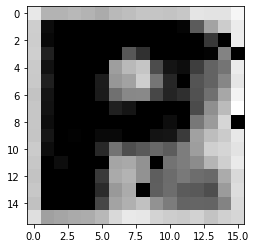

In [59]:
predictions = ds3_model.predict(X_test)

plt.imshow(predictions[1].reshape(16,16),cmap='gray')

# display(X_test, predictions, ds_1_images)




# ALL_DS_3_PREDICTIONS[0] = []
# for i in range(len(predictions)):
#     ALL_DS_3_PREDICTIONS[0].append((ds_1_images[int(i)], ds_1_images[predictions[i]]))

# print(predictions)
# print(X_test.shape)

# i = random.randint(1,len(predictions)-1)
# print(i)
# fig, axis= plt.subplots(1,2)
# plt.subplots_adjust(top=1)
# axis[0].imshow(X_test[i,:,:,0])
# axis[1].imshow(ds_1_images[predictions[i]])
# fig, axis= plt.subplots(1,2)
# plt.subplots_adjust(top=1)
# axis[0].set_title('ASL sign')
# axis[1].set_title('Predicted Image')
# axis[0].imshow(X_test[TEST_DATA_LABELS.index(i),:,:,0], cmap="gray")
# axis[1].imshow(ds_1_images[int(i)], cmap='gray')

#---------- Clear Images (Optional)-------------#


Adding Noise to Dataset 3

In [8]:
#------- Adding noise to dataset --------------#
noisy(imageTensor(DATASET_3_TRAIN_PATH), NOISY_DATASET_3_PATH)

array([[220.        , 191.        , 192.        , ..., 189.        ,
        187.        , 185.        ],
       [214.        , 180.        , 182.        , ..., 181.        ,
        179.        , 178.        ],
       [214.        , 183.        , 184.        , ..., 182.        ,
        182.        , 180.        ],
       ...,
       [229.        , 216.        , 220.        , ..., 202.        ,
        145.        , 111.        ],
       [229.        , 217.        , 219.        , ..., 142.        ,
        108.        ,  97.        ],
       [228.88992791, 217.        , 218.        , ..., 106.57109135,
        102.        ,  97.        ]])

Predicting Noise Added Images over Original Images

Predictions for Noisy data with Standard Deviation


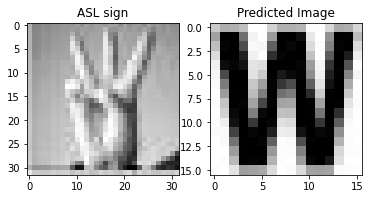

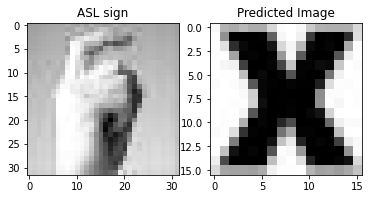

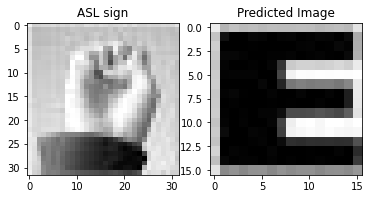

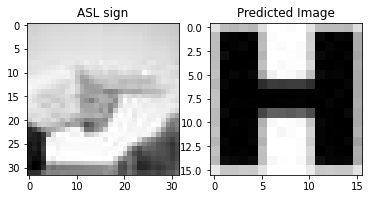

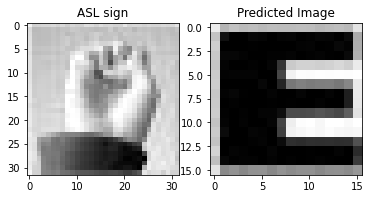

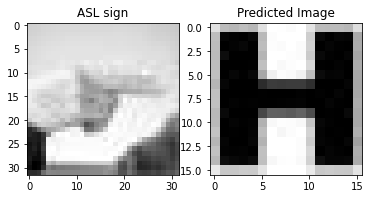

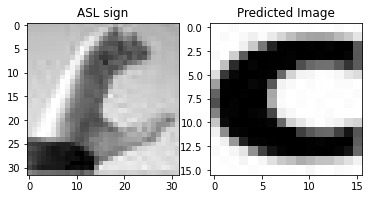

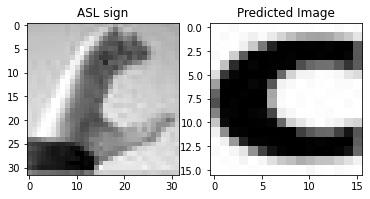

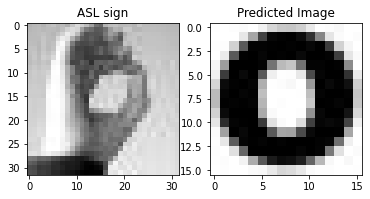

In [9]:
#------- Predicting the noisy images with the model --------------#
print("Predictions for Noisy data with Standard Deviation")
for std in STANDARD_DEVIATIONS:
    ds3_noisy_model = imageTensor(f"{NOISY_DATASET_3_PATH}{std}/")
    ds3_noisy_model = ds3_noisy_model / 255
    ds3_noisy_model = ds3_noisy_model.reshape(ds3_noisy_model.shape[0], *(32,32,1))

    ds3_noisy_predict =  np.argmax(ds3_model.predict(ds3_noisy_model), axis=-1)
    
    display(ds3_noisy_model, ds3_noisy_predict, ds_1_images, std)

    ALL_DS_3_PREDICTIONS[std] = []
    for i in range(len(ds3_noisy_predict)):
        ALL_DS_3_PREDICTIONS[std].append((ds_1_images[i], ds_1_images[ds3_noisy_predict[i]]))

In [10]:
#------- Function for calculating FFA and FH values --------------#
def calculate_fh_ffa(original_data, predicted_data):
    '''
        original_data: Original Image data
        predicted_data: Predicted Image data
        
    '''    
    original_data = np.where(original_data<np.mean(original_data),0,1).astype('float64')
    predicted_data = np.where(predicted_data<np.mean(predicted_data),0,1).astype('float64')
    

    correctly_predicted_black_pixels_count = 0
    wrongly_predicted_black_pixels_count = 0

    whites_original = np.count_nonzero(original_data==0)
    blacks_original = np.count_nonzero(original_data==1)

    for i in range(16):
        for j in range(16):
            if original_data[i][j] == 1 and predicted_data[i][j] == 1:
                correctly_predicted_black_pixels_count += 1
            elif original_data[i][j] == 0 and predicted_data[i][j] == 1:
                wrongly_predicted_black_pixels_count += 1
                
    fh = correctly_predicted_black_pixels_count/blacks_original
    ffa = wrongly_predicted_black_pixels_count/whites_original
    
    return fh,ffa

In [11]:
#------- Calculating the FFA and FH values for all the Predicted Images for both Trained and Noisy datasets --------------#
for k,v in ALL_DS_3_PREDICTIONS.items():
    ALL_DS_3_METRICS[k] = {}
    
    for i in range(len(v)):
        ALL_DS_3_METRICS[k][i] = calculate_fh_ffa(v[i][0],v[i][1])

#------- Displaying all the FFA and FH values for each image of a specific standard deviation --------------#
print(ALL_DS_3_METRICS)


{0: {0: (1.0, 0.0), 1: (1.0, 0.0), 2: (1.0, 0.0), 3: (1.0, 0.0), 4: (1.0, 0.0), 5: (1.0, 0.0), 6: (1.0, 0.0), 7: (1.0, 0.0), 8: (1.0, 0.0), 9: (1.0, 0.0), 10: (1.0, 0.0), 11: (1.0, 0.0), 12: (1.0, 0.0), 13: (1.0, 0.0), 14: (1.0, 0.0), 15: (1.0, 0.0), 16: (1.0, 0.0), 17: (1.0, 0.0), 18: (1.0, 0.0), 19: (1.0, 0.0), 20: (1.0, 0.0), 21: (1.0, 0.0), 22: (1.0, 0.0), 23: (1.0, 0.0)}, 0.001: {0: (1.0, 0.0), 1: (1.0, 0.0), 2: (0.7446808510638298, 0.3739130434782609), 3: (0.6153846153846154, 0.3597122302158273), 4: (0.7083333333333334, 0.28125), 5: (0.6554621848739496, 0.36496350364963503), 6: (0.6721311475409836, 0.3283582089552239), 7: (0.6333333333333333, 0.47794117647058826), 8: (0.4887640449438202, 0.2564102564102564), 9: (0.6614173228346457, 0.3333333333333333), 10: (0.6216216216216216, 0.6203703703703703), 11: (0.7049180327868853, 0.3358208955223881), 12: (0.6283185840707964, 0.48951048951048953), 13: (0.5703125, 0.421875), 14: (0.6904761904761905, 0.3769230769230769), 15: (0.624113475177

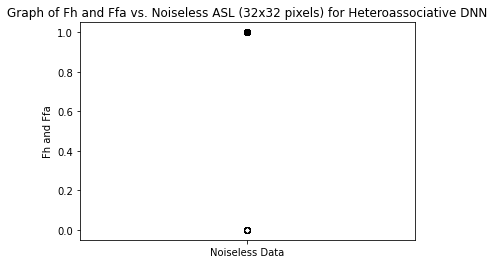

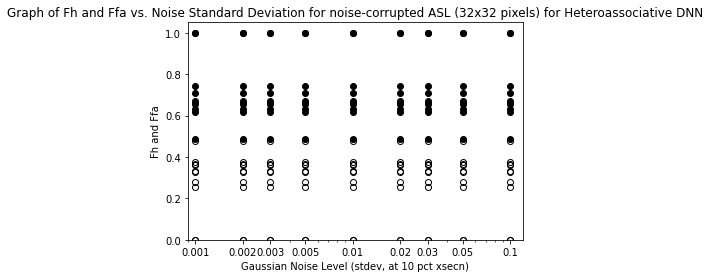

In [12]:
plot_data(ALL_DS_3_METRICS[0], noiseless=True)

plot_data(ALL_DS_3_METRICS)


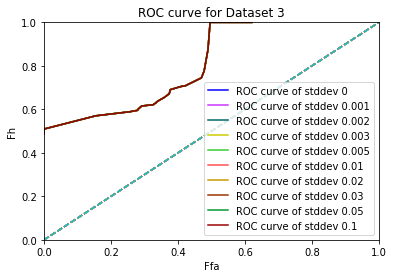

In [13]:
#ROC Curve
colors = ['#0000ff', '#cc33ff', '#006666', '#cccc00', '#33cc33', '#ff5050', '#cc9900', '#993300', '#009933', '#990000']
roc_fh_values = {}
roc_ffa_values = {}
for std in ALL_DS_3_METRICS.keys():
    roc_fh_values[std] = []
    roc_ffa_values[std] = []
    for i in ALL_DS_3_METRICS[std].keys():
        roc_fh_values[std].append(ALL_DS_3_METRICS[std][i][0])
        roc_ffa_values[std].append(ALL_DS_3_METRICS[std][i][1])

fig,ax = plt.subplots()
for std, color in zip(ALL_DS_3_METRICS.keys(), colors):
    fh = roc_fh_values[std]
    ffa = roc_ffa_values[std]
    fh.sort()
    ffa.sort()

    ax.plot(ffa,fh, color=color, label= f"ROC curve of stddev {std}")
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('Ffa')
    ax.set_ylabel('Fh')
    ax.set_title("ROC curve for Dataset 3")
    ax.legend(loc="lower right")